### Section B CA1 RNN

Name: Jovan Heng Ghim Hong

Class: DAAA/2B/22

Admin No: 2401418

In [4]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [459]:
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
import random
import re
import gc
import math

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense , Dropout, LSTM, GRU, SimpleRNN, Embedding, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet, stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer
from scipy.sparse  import hstack

nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\JOVAN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\JOVAN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\JOVAN\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\JOVAN\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\JOVAN\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JOVAN\AppData\Roaming\nl

In [6]:
df = pd.read_csv(os.path.join('datasets' , 'Movie reviews.csv'))

##### Basic Data Exploration

In [7]:
df

,Review,Score,"Are there ways for you to generate more data? Spliting up sentences, would that help?",Language
0,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.1,NaN,Malay
1,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.9,NaN,Malay
2,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.5,NaN,Malay
3,"Sayang sekali, pelakon tidak memberikan persem...",0.8,NaN,Malay
4,Jalan cerita yang kompleks dan penuh emosi. Su...,0.2,NaN,Malay
...,...,...,...,...
522,Pening,0.7,NaN,Malay
523,Berkesan,0.2,NaN,Malay
524,Mengujakan,0.1,NaN,Malay
525,Sederhana and teruk,0.6,NaN,Malay


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527 entries, 0 to 526
Data columns (total 4 columns):
 #   Column                                                                                 Non-Null Count  Dtype  
---  ------                                                                                 --------------  -----  
 0   Review                                                                                 527 non-null    object 
 1   Score                                                                                  525 non-null    float64
 2   Are there ways for you to generate more data? Spliting up sentences, would that help?  0 non-null      float64
 3   Language                                                                               527 non-null    object 
dtypes: float64(2), object(2)
memory usage: 16.6+ KB


Col index 2 is a hint not actual usable data

Hint: **Are there ways for you to generate more data? Spliting up sentences, would that help?**

In [9]:
df.drop(columns='Are there ways for you to generate more data? Spliting up sentences, would that help?', inplace=True)

In [10]:
df['Language'].unique()

array(['Malay', 'English', 'Chinese', 'Nippon'], dtype=object)

In [11]:
# Note sure what Nippon is
df[df['Language'] == 'Nippon']

,Review,Score,Language
484,Nani kore,0.997413,Nippon


Looks like **Nippon** is **Japanese**, **Nani Kore** roughly translating to **What's This?** (condescendingly)

In [12]:
df.iloc[0:3]
           

,Review,Score,Language
0,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.1,Malay
1,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.9,Malay
2,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.5,Malay


These 3 have the same review but different score

In [13]:
df.iloc[0]['Review']

'Filem ini hebat! Aksi yang mendebarkan dan plot yang mengejutkan.'

Acoording to **Google Translate** this roughly translates to _This movie is great! Thrilling action and a surprising plot_

##### Trying to figure out what **Score** means

In [14]:
df[(df['Language'] == 'English') & (df['Score'] > 0.75)]

,Review,Score,Language
212,Avengers: Endgame is disappointing and too cli...,0.85,English
219,I'm not satisfied with how the main actors del...,0.80,English
236,This film is very disappointing. Not worth the...,0.80,English
262,Lack of character development makes this film ...,0.80,English
294,This film is highly disappointing. It fails to...,0.80,English
430,Disappointing,0.80,English
472,Disappointing resolution,0.80,English


In [15]:
df[(df['Language'] == 'English') & (df['Score'] < 0.25)]

,Review,Score,Language
206,This movie is amazing! The action is breathtak...,0.08,English
208,The storyline is touching and full of emotion....,0.12,English
209,This movie delivers an outstanding experience....,0.05,English
211,I'm thrilled throughout the movie. Engaging st...,0.15,English
214,This film is truly impressive with deep emotio...,0.12,English
...,...,...,...
501,"Visually stunning, emotionally resonant journey",0.08,English
502,"Compelling story, outstanding performances",0.12,English
503,"Intricate plot, unexpected twists",0.10,English
505,"Breathtaking visuals, engaging narrative",0.08,English


Contrary to what may be expected, **a lower score actually represents more positive reviews**

Therefore score can roughly be defined as **How much I dislike this movie**.

Likewise rows with missing scores can be infered as **un-sentimental review** (like just stopwords or generic words)

In [16]:
df[df['Score'].isnull()]

,Review,Score,Language
426,Ni hao,NaN,Chinese
493,Diabolic,NaN,English


In [17]:
# We can drop the missing score cols
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 525 entries, 0 to 526
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Review    525 non-null    object 
 1   Score     525 non-null    float64
 2   Language  525 non-null    object 
dtypes: float64(1), object(2)
memory usage: 16.4+ KB


In [18]:
## Looking at chinese reviews
df[df['Language'] == 'Chinese']

,Review,Score,Language
427,Hen tai fei chang hao,0.001,Chinese


In [19]:
df[df['Language'] == 'Malay']

,Review,Score,Language
0,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.1,Malay
1,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.9,Malay
2,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.5,Malay
3,"Sayang sekali, pelakon tidak memberikan persem...",0.8,Malay
4,Jalan cerita yang kompleks dan penuh emosi. Su...,0.2,Malay
...,...,...,...
522,Pening,0.7,Malay
523,Berkesan,0.2,Malay
524,Mengujakan,0.1,Malay
525,Sederhana and teruk,0.6,Malay


In [20]:
df[df['Language'] == 'English']

,Review,Score,Language
206,This movie is amazing! The action is breathtak...,0.08,English
207,I'm disappointed with the actors' performance....,0.70,English
208,The storyline is touching and full of emotion....,0.12,English
209,This movie delivers an outstanding experience....,0.05,English
210,"Too many action scenes, sometimes unnecessary....",0.40,English
...,...,...,...
502,"Compelling story, outstanding performances",0.12,English
503,"Intricate plot, unexpected twists",0.10,English
504,"Underwhelming moments, weak characterizations",0.60,English
505,"Breathtaking visuals, engaging narrative",0.08,English


Currently there is insufficient data for Chinese and Japan to effectively train our model, for the sake of it we will **drop both chinese and japan reviews**

In [21]:
df = df[~df['Language'].isin(['Chinese', 'Japanese'])]

In [22]:
# View Duplicated Columns
df[df.duplicated(subset='Review' , keep=False)]

,Review,Score,Language
0,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.10,Malay
1,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.90,Malay
2,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.50,Malay
16,Jalan cerita yang rumit tetapi sangat menarik....,0.20,Malay
18,Filem ini benar-benar membuat saya terbawa sua...,0.10,Malay
...,...,...,...
433,Impressive,0.08,English
442,Complex,0.10,English
446,Intriguing,0.12,English
447,Moving,0.12,English


Since we have both Malay and English, we will **translate the malay reviews to english**

It will regress on the scores, trying to predict the sentiment for future/new data

In [23]:
from deep_translator import GoogleTranslator
import time

def translate_malay_to_english(text, max_retries=3):
    for attempt in range(max_retries):
        try:
            translator = GoogleTranslator(source='ms', target='en')
            translated = translator.translate(text)
            return translated if translated else text
        except:
            time.sleep(2)  # Simple delay between retries
    return text  # Return original if all retries fail

# Apply translation to Malay reviews
df_malay = df[df['Language'] == 'Malay'].copy()
df_malay['Review'] = df_malay['Review'].apply(translate_malay_to_english)
df_malay['Language'] = 'English'

# Combine with English reviews
df_english = pd.concat([df[df['Language'] == 'English'], df_malay], ignore_index=True)

<style>
  /*responsive*/
  img {
    width: 100%;
    height: auto;
  }
  </style>
##### What to do with duplicated reviews?

Currently there are some reviews (shown earlier in cell 13) where they are the **exact same review but with different scores**

**Why not take mean?**

As shown below, taking the mean will result in a score of 0.5

<img src='./markdown/dup_malay_reviews.png'>

<br>

This does not reflect on what the actual review means _('This movie is great! Thrilling action and a surprising plot')_

##### What do we do?? 

Simply we can drop all of the duplicated review, this prevents inconsistencies _(like shown above)_ from affecting our data.


--- 

In [24]:
df_english = df_english.drop_duplicates(subset='Review', keep='first').reset_index(drop=True)

##### Anamoly Detection

As nature of language, **sarcasm** exists. 

To detect this we can cluster the sentiments against the TF-IDF vectorization.

This allows us to detect any 'sarcasm' within our dataset.

In [25]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df_english['Review'])

In [26]:
features = hstack([tfidf_matrix , df_english['Score'].values.reshape(-1 , 1)])

In [27]:
kmeans = KMeans(n_clusters=2 , random_state=42)
kmeans.fit(features)

KMeans(n_clusters=2, random_state=42)

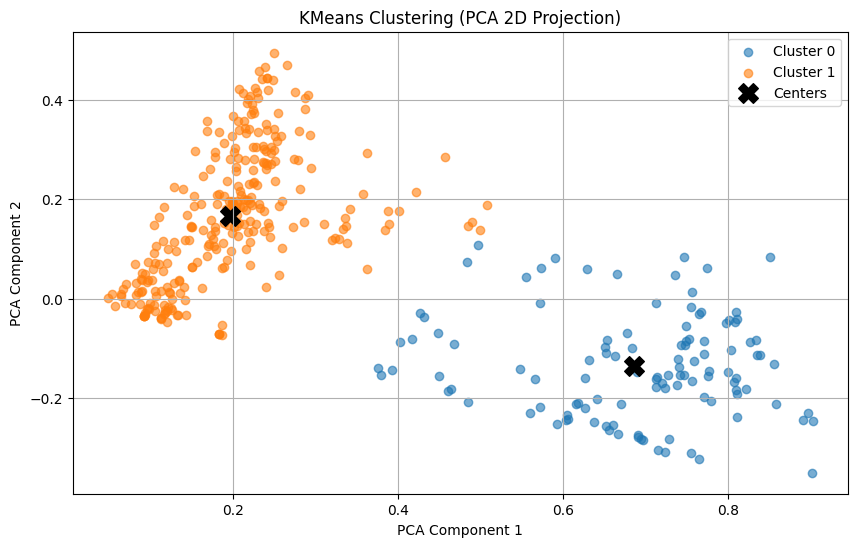

In [28]:
# plotting it
trunc = TruncatedSVD(n_components=2 , random_state=42)
features_2d = trunc.fit_transform(features)

labels = kmeans.labels_


plt.figure(figsize=(10, 6))

for i in range(2):
    cluster_points = features_2d[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {i}", alpha=0.6)

# Optional: Plot cluster centers
centers_2d = trunc.transform(kmeans.cluster_centers_)
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c='black', marker='X', s=200, label='Centers')

plt.title("KMeans Clustering (PCA 2D Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# Compute distance from each point to its assigned cluster center
closest, distances = pairwise_distances_argmin_min(features, kmeans.cluster_centers_)

In [60]:
len(df_english)

393

In [72]:
df_english['Cluster'] = kmeans.labels_
df_english['DistanceToCenter'] = distances

top_5_percent = round(len(df_english) * 0.05)

# Sort within each cluster to find outliers
outliers = df_english.sort_values(by='DistanceToCenter', ascending=False)

In [73]:
for i, row in outliers.head(top_5_percent).iterrows():
    print(f"\n[Cluster {row['Cluster']} | Distance: {row['DistanceToCenter']:.3f} | Score: {row['Score']}]")
    print(row['Review'])



[Cluster 0 | Distance: 1.069 | Score: 0.99]
Sad

[Cluster 0 | Distance: 1.041 | Score: 0.4]
Overwhelming

[Cluster 0 | Distance: 1.035 | Score: 0.4]
Impactful

[Cluster 0 | Distance: 1.028 | Score: 0.4]
Overwhelming action

[Cluster 0 | Distance: 1.027 | Score: 0.8]
Stir

[Cluster 1 | Distance: 1.027 | Score: 0.2]
Blame

[Cluster 1 | Distance: 1.027 | Score: 0.2]
Effective

[Cluster 1 | Distance: 1.027 | Score: 0.2]
Adorable

[Cluster 1 | Distance: 1.027 | Score: 0.2]
Tempting

[Cluster 0 | Distance: 1.026 | Score: 0.4]
Impactful moments

[Cluster 0 | Distance: 1.024 | Score: 0.5]
Inconsistent

[Cluster 1 | Distance: 1.024 | Score: 0.1]
Rock

[Cluster 1 | Distance: 1.024 | Score: 0.1]
Fabulous

[Cluster 1 | Distance: 1.024 | Score: 0.1]
Perfect

[Cluster 1 | Distance: 1.024 | Score: 0.1]
Entertain

[Cluster 1 | Distance: 1.023 | Score: 0.05]
Masterpiece

[Cluster 1 | Distance: 1.023 | Score: 0.06]
Mesmerizing

[Cluster 1 | Distance: 1.023 | Score: 0.2]
Emotion

[Cluster 1 | Distance: 

##### Results

The top "anomalous" reviews shows a mapping of **adjectives to its sentiment score**

This is really good data for the RNN, it down right tells my model **what adjectives to look out for** in positive and negative reviews

**However**, we want to see the **full reviews that are most anomalous**

--- 

I basically just manually scrolled through the DataFrame until i found the start of those reviews

This can be done easily with the DatraWrangler extension in VScode

In [75]:
outliers.tail(393 - 102)

,Review,Score,Language,Cluster,DistanceToCenter
276,Excessive and shocking action scenes. Sometime...,0.40,English,0,0.998790
60,The abundance of action scenes is exhilarating...,0.30,English,1,0.998789
270,"Breathtaking visuals, engaging narrative",0.08,English,1,0.998711
224,Underwhelming moments,0.60,English,0,0.997425
79,The actors struggle to embody their characters...,0.70,English,0,0.996575
...,...,...,...,...,...
333,Visual Effects and the design of this movie is...,0.10,English,1,0.921784
129,The performances of the cast in Avengers: Endg...,0.12,English,1,0.921219
350,The visual quality of this movie is amazing. E...,0.10,English,1,0.915730
324,Visual Effects and the animation of this movie...,0.10,English,1,0.915342


##### Key Takeaways


1. The range of positive, neutral and negative reviews **are not equal**

e.g.

_'Underwhelming moments'_ has a score of 0.6. 

Underwhelming moments is clearly a **light negative review**, suggesting that 0.6 might be the **'start of negative reviews'**

--- 

_'The abundance of action scenes is exhilarating. A bit overwhelming at times.'_ has a score of 0.3

'exhilarating' suggest positive, but it is lightly critiqued with 'A bit overwhelming at times'. This suggests that this can be a **lightly positive - neutral** review. Therefore 0.3 might be the **'point between positive and neutral reviews'**

--- 

_'Excessive and shocking action scenes. Sometimes it's too much.'_

The sentence structure suggests that this is a **'neutral review'**  and it has a score of 0.4, which falls into our 'predicted range' of sentiments


2. There are some mislabelled reviews

**indexes: [4 , 342]**

e.g.

'Too many action scenes, sometimes unnecessary. Too dramatic.' has a score of 0.4

This is clearly a negative review. Eventhouugh 'sometimes' softens the blow, it should not be classified as 'neutral' but 'negative'

3. "Plot Twist"

**index: [246]**

It was labelled with a score of 0.7, with is 'negative'

But "Plot Twist" is **Context dependent** and on its own it is just Neutral.

So i will change the score down to 0.4


In [77]:
df_english.at[246 , 'Score'] = 0.5
df_english.at[4 , 'Score'] = 0.65
df_english.at[342 , 'Score'] = 0.65

---

##### Data Engineering

Currently our data is too little to train a NN. We need to force out more data from this dataset

##### How to Force

1. We will split sentences into clauses, **usually seperated via punctuation**

e.g.

> This movie is amazing! The action is breathtaking, and the plot is intriguing.

can become:

> This movie is amazing! 

> The action is breathtaking

> the plot is intriguing

We can assign new scores to each subsentence

---

2. From the Clauses we can **Join with Conjunctions**

e.g. 

> This movie is amazing! 

> The action is breathtaking

can become: 

> The movie is amazing and the action is breathtaking. 

---

3. We can perform **sentence shuffling around a conjunction**

e.g. 

> The movie is amazing and the action is breathtaking. 

can become:

> The action is breathtaking and the movie is amazing.

---

4. We can **shuffle adjective to its synonyms and antonyms**

e.g.

> The movie is amazing and the action is breathtaking

can become: 

> The movie is astonishing and the action is spectacular


We can use the 'key value paired' adjectives (mentioned above during anomaly detection) as a _'word bank'_ to find such synonyms and antonyms

--- 

In [79]:
def get_synonym(word):
  synonyms = set()
  for syn in wordnet.synsets(word, pos=wordnet.ADJ):
    for lemma in syn.lemmas():
        if lemma.name().lower() != word.lower():
            synonyms.add(lemma.name().replace("_", " "))
  
  return synonyms.pop() if synonyms else None # popping a set gives something random

In [80]:
def get_antonym(word):
    antonyms = set()
    for syn in wordnet.synsets(word, pos=wordnet.ADJ):
        for lemma in syn.lemmas():
            for ant in lemma.antonyms():             # Check for antonyms
                antonyms.add(ant.name().replace("_", " "))
    return antonyms.pop() if antonyms else None

In [309]:
def get_similar_adjective(word, adjective_dictionary):
  if word not in adjective_dictionary:
    return []
  word_score = adjective_dictionary[word]
  margin = 0.03

  synonyms = [adj for adj , score in adjective_dictionary.items() 
             if abs(score - word_score) <= margin
              ]

  return synonyms

In [310]:
def get_non_similar_adjective(word, adjective_dictionary):
  if word not in adjective_dictionary:
    return []

  word_score = 1 - adjective_dictionary[word]
  margin = 0.03

  antonyms = [adj for adj , score in adjective_dictionary.items() 
             if abs(score - word_score) <= margin
              ]

  return antonyms

In [169]:
# def adjective_replacement(df, adj_dict):
#   reviews = df['Review']
#   scores = df['Score']

#   results = pd.DataFrame({
#     'Review': [], 'Score': []
#   })

#   for review , score in zip(reviews , scores):
#     tokens = word_tokenize(review)
#     tagged_review = pos_tag(tokens)
    
#     # synonym and antonym replacement
#     pos_reviews = []
#     neg_reviews = []
#     for word , tag in tagged_review:
#       if tag.startswith('JJ'):
#         adj_dict_syns = get_similar_adjective(word.lower() ,adj_dict) 
#         adj_dict_antys = get_non_similar_adjective(word.lower() ,adj_dict)

#         if adj_dict_syns:
#           pos_reviews.append(adj_dict_syns)
#         else:
#           syns = get_synonym(word.lower())
#           pos_reviews.append(syns if syns else word)
          
#         if adj_dict_antys:
#           neg_reviews.append(adj_dict_antys)
#         else:
#           antys = get_antonym(word.lower())
#           neg_reviews.append(antys)
          
#       else:
#         pos_reviews.append(word)
#         neg_reviews.append(word)

#     pos_reviews = TreebankWordDetokenizer().detokenize(pos_reviews)
#     neg_reviews = TreebankWordDetokenizer().detokenize(neg_reviews)

#     # i dont want to duplicate sentences
#     if pos_reviews == review: 
#       pos_reviews = np.nan

#     if neg_reviews == review: 
#       neg_reviews = np.nan
    
#     ## Creating record
#     results = pd.concat([results,
#                          pd.DataFrame({
#                           'Review': [pos_reviews , neg_reviews],
#                           'Score': [score , 1-score],
#                          })
#     ], ignore_index=True)

#   return results.dropna().drop_duplicates(subset='Review')
    


In [412]:
def adjective_replacement(df, adj_dict):
  reviews = df['Review']
  scores = df['Score']

  results = pd.DataFrame({
    'Review': [], 'Score': []
  })

  for review , score in zip(reviews , scores):
    tokens = word_tokenize(review)
    tagged_review = pos_tag(tokens)
    
    # synonym and antonym replacement
    pos_reviews = []
    neg_reviews = []
    aug_scores = []
    review_adj_map = {}

    # get syns and antys for all adjectives
    for word , tag in tagged_review:
      if tag.startswith('JJ'):
        syns = get_similar_adjective(word.lower() , adj_dict)
        antys = get_non_similar_adjective(word.lower() , adj_dict)
        review_adj_map[word] = [syns , antys]
        

    # Create record
    antys_size = 0
    for word, [syns , antys] in review_adj_map.items():
      for syn in syns:
        aug_review = review.replace(word , syn)
        pos_reviews.append(aug_review)
        
        # Calculate semantic shift (max 20% change)
        sentiment_shift = min(0.2, abs(adj_dict[word.lower()] - adj_dict[syn]) / 2)
        # Maintain direction but adjust intensity
        if adj_dict[syn] > adj_dict[word.lower()]:
            aug_scores.append(score * (1 + sentiment_shift))
        else:
            aug_scores.append(score * (1 - sentiment_shift))

      antys_size += len(antys)
    
    # antonyms need to be handled differently
    # since all of the adjectives need to be transformed at once
    for _ in range(antys_size):  
      aug_review = review
      current_score = 0.5 + (0.5 - score)  # This flips around 0.5

      for word , tag in tagged_review:
        if word in review_adj_map.keys():
          [_ , antys] = review_adj_map[word]
          if len(antys) == 0:
            aug_review = None
            break

          aug_review = aug_review.replace(word , antys[0])

          review_adj_map[word][1] = review_adj_map[word][1][1:] 

          # score adjust
          orig_intensity = abs(0.5 - adj_dict[word.lower()])
          anty_intensity = abs(0.5 - adj_dict[antys[0]])
          intensity_ratio = anty_intensity / orig_intensity if orig_intensity != 0 else 1

          current_score = 0.5 + ((current_score - 0.5) * intensity_ratio)
      
      if aug_review == None:
        break
      else:
        neg_reviews.append(aug_review)
        aug_scores.append(max(0 , min(1 , current_score)))
    
    # Concat to results
    results = pd.concat([results , pd.DataFrame({
      'Review': pos_reviews + neg_reviews,
      'Score': aug_scores
    })] , ignore_index=True)
        
  return results.dropna().drop_duplicates(subset='Review')
    



In [403]:
def get_clauses(df):
  reviews = df['Review']
  scores = df['Score']

  results = pd.DataFrame({
    'Review': [], 'Score': []
  })

  # sub clauses
  for review, score in zip(reviews , scores):

    total_words = len(review.split(' '))

    clauses = re.split(r'[.?!,]' , review.strip())

    cleaned_clauses = [c.strip() for c in clauses if c != '']

    # remove additional 'and'
    for i in range(len(cleaned_clauses)):
      if cleaned_clauses[i].strip().startswith('and'):
        cleaned_clauses[i] = cleaned_clauses[i].strip()[3:]

      # This isn't grammatically correct but incase
      if cleaned_clauses[i].strip().endswith('and'):
        cleaned_clauses[i] = cleaned_clauses[i].strip()[:-3]


    
    for i , clause in enumerate(cleaned_clauses):
      clause = clause.strip() # remove additional whitespace
      multiplier = len(clause.split(' ')) / total_words

      results = pd.concat([results,
                 pd.DataFrame({
                    'Review': [clause],
                    'Score': [score * multiplier]            
                 })
      ], ignore_index=True)
                  

      # clause join and rotation about conjunction
      if i != len(cleaned_clauses) -1:
        conjuction_clauses = [f'{clause} and {cleaned_clauses[i + 1]}' ,f'{cleaned_clauses[i + 1]} and {clause}' ]
        multiplier = (len(clause.split(' ')) + len(cleaned_clauses[i + 1].split(' '))) / total_words

        results = pd.concat([results,
                   pd.DataFrame({
                      'Review': conjuction_clauses,
                      'Score': [score * multiplier] * 2           
                   })
        ], ignore_index=True)
  return results.dropna().drop_duplicates(subset='Review')
  

First thing is to **train_test_split** the raw data, this prevents **data leakage**

##### Creating 'Classes'

When i train-test-split my data, i want it to be somewhat stratified

A way that i can achieve this is to **label my data**, allowing me to stratify when i split the data.

##### How to split

As observered above, there are some adjectives - score _'key value pairs'_

This is **crucial data for my RNN** as such i should remove it and use it inside of my **train data**

In [95]:
def create_label(score):
  if score >= 0.6:
    return 0
  elif score >= 0.35: 
    return 1 
  else: 
    return 2
# 0 neg , 1 neutral , 2 pos

In [96]:
df_english['Review Type'] = df_english['Score'].apply(create_label)

In [364]:
df_english

,Review,Score,Language,Cluster,DistanceToCenter,Review Type
0,This movie is amazing! The action is breathtak...,0.08,English,1,0.908870,2
1,I'm disappointed with the actors' performance....,0.70,English,0,0.964013,0
2,The storyline is touching and full of emotion....,0.12,English,1,0.959562,2
3,This movie delivers an outstanding experience....,0.05,English,1,0.971211,2
4,"Too many action scenes, sometimes unnecessary....",0.65,English,0,0.983934,0
...,...,...,...,...,...,...
388,Dizzy,0.70,English,0,1.018202,0
389,Effective,0.20,English,1,1.026562,2
390,Exciting,0.10,English,1,1.021941,2
391,Moderate and severe,0.60,English,0,1.013062,0


I want to make higher good and lower bad (its more intuitive for me)

In [365]:
df_english['Score'] = df_english['Score'].apply(lambda x: 1- x)

In [366]:
# selecting my 'adjective list'  
adjective_list = df_english[df_english['Review'].str.split(' ').str.len() <= 2]
adjective_list

,Review,Score,Language,Cluster,DistanceToCenter,Review Type
175,Masterpiece,0.95,English,1,1.023424,2
176,Spectacular,0.92,English,1,1.017513,2
177,Emotional,0.93,English,1,1.003996,2
178,Epic,0.94,English,1,1.009145,2
179,Thrilling,0.90,English,1,1.011943,2
...,...,...,...,...,...,...
387,Adorable,0.80,English,1,1.026562,2
388,Dizzy,0.30,English,0,1.018202,0
389,Effective,0.80,English,1,1.026562,2
390,Exciting,0.90,English,1,1.021941,2


In [367]:
splitable_reviews = df_english[~df_english.index.isin(adjective_list.index)]
splitable_reviews

,Review,Score,Language,Cluster,DistanceToCenter,Review Type
0,This movie is amazing! The action is breathtak...,0.92,English,1,0.908870,2
1,I'm disappointed with the actors' performance....,0.30,English,0,0.964013,0
2,The storyline is touching and full of emotion....,0.88,English,1,0.959562,2
3,This movie delivers an outstanding experience....,0.95,English,1,0.971211,2
4,"Too many action scenes, sometimes unnecessary....",0.35,English,0,0.983934,0
...,...,...,...,...,...,...
373,The movie is really impressive with a deep emo...,0.88,English,1,0.960357,2
374,Surprising action and shocking plot. I'm impre...,0.88,English,1,0.976276,2
375,I am dissatisfied with the way the main actor ...,0.20,English,0,0.978241,0
376,Complex but very interesting storyline. I love...,0.80,English,1,0.981517,2


60-20-20 split

In [368]:
X_train, X_test, y_train, y_test = train_test_split(splitable_reviews['Review'] , splitable_reviews['Score'] , train_size=0.8 , random_state=42, stratify=splitable_reviews['Review Type'])

In [369]:
X_train , X_val , y_train , y_val= train_test_split(X_train, y_train, train_size=0.75, random_state=42, stratify=splitable_reviews.loc[X_train.index, 'Review Type'])

##### Data Augmentation


reformat some of the data for us to work with

In [413]:
augmentable_df = pd.DataFrame({
  'Review': X_train.values,
  'Score': y_train.values,
})

In [414]:
adjective_list_dict = dict(zip(adjective_list['Review'].str.lower() , adjective_list['Score']))
adjective_list_dict = {k:v for k , v in adjective_list_dict.items() if len(k.split(' ')) == 1}

In [415]:
adjective_list_dict

{'masterpiece': 0.95,
 'spectacular': 0.92,
 'emotional': 0.9299999999999999,
 'epic': 0.94,
 'thrilling': 0.9,
 'compelling': 0.88,
 'underwhelming': 0.4,
 'intriguing': 0.85,
 'touching': 0.9,
 'mesmerizing': 0.94,
 'flat': 0.35,
 'exhilarating': 0.9,
 'impressive': 0.92,
 'inconsistent': 0.5,
 'breathtaking': 0.92,
 'outstanding': 0.88,
 'complex': 0.35,
 'surprising': 0.9,
 'unsatisfying': 0.30000000000000004,
 'moving': 0.88,
 'incredible': 0.92,
 'weak': 0.25,
 'great': 0.92,
 'overwhelming': 0.6,
 'confusing': 0.30000000000000004,
 'captivating': 0.88,
 'top-notch': 0.92,
 'disappointing': 0.19999999999999996,
 'challenging': 0.35,
 'intense': 0.9,
 'missed': 0.25,
 'entertaining': 0.88,
 'over-the-top': 0.6,
 'twist': 0.30000000000000004,
 'striking': 0.88,
 'ordinary': 0.35,
 'amazing': 0.88,
 'engaging': 0.94,
 'unconvincing': 0.25,
 'enriching': 0.87,
 'impactful': 0.6,
 'reintroduces': 0.88,
 'action-packed': 0.9,
 'tempting': 0.8,
 'sad': 0.010000000000000009,
 'blame': 0.

Creating data

In [416]:
# Create additional data
additional_data_english = get_clauses(augmentable_df)

In [417]:
additional_data_english

,Review,Score
0,The action sequences in Avengers: Endgame are ...,0.160000
1,The action sequences in Avengers: Endgame are ...,0.440000
2,delivering a level of intensity that keeps aud...,0.440000
3,delivering a level of intensity that keeps aud...,0.280000
4,delivering a level of intensity that keeps aud...,0.580000
...,...,...
1039,The emotional depth of the characters is portr...,0.518974
1040,The emotional depth of the characters is portr...,0.225641
1041,The emotional depth of the characters is portr...,0.361026
1042,creating a connection with the audience and Th...,0.361026


Here i want to perform adjective swapping on the _additional_data_english_ dataset.

**Why?** 

Since Clauses are smaller and simplier , they have **easier grammar** that allows for my function to work better

In [418]:
adjective_swaped_cluases = adjective_replacement(additional_data_english, adjective_list_dict)

In [419]:
adjective_swaped_cluases

,Review,Score
0,The storytelling is exceptional and the perfo...,0.616821
1,The storytelling is exceptional and the perfo...,0.610714
2,The storytelling is exceptional and the perfo...,0.616821
3,The storytelling is exceptional and the perfo...,0.616821
4,The storytelling is exceptional and the perfo...,0.610714
...,...,...
4871,creating a connection with the audience and Th...,0.355610
4872,creating a connection with the audience and Th...,0.355610
4873,creating a connection with the audience and Th...,0.355610
4874,creating a connection with the audience and Th...,0.355610


In [378]:
adjective_swapped_raw = adjective_replacement(augmentable_df, adjective_list_dict)

In [379]:
adjective_swapped_raw

,Review,Score
0,This film is a masterpiece! The storytelling i...,0.97
1,This film is a masterpiece! The storytelling i...,0.95
2,This film is a masterpiece! The storytelling i...,0.97
3,This film is a masterpiece! The storytelling i...,0.97
4,This film is a masterpiece! The storytelling i...,0.95
...,...,...
1509,Avengers: Endgame expertly balances moments of...,0.85
1510,Avengers: Endgame expertly balances moments of...,0.85
1511,Avengers: Endgame expertly balances moments of...,0.85
1512,Avengers: Endgame expertly balances moments of...,0.85


However from manual inspection i can see some issues:

1. There are rows like **'The storyline is touching and empty of emotion and I love it'** with score of 0.88

It is obviously not that **'negative'** of a review, but it has such a high score _(suggesting very negative)_

--- 

**Solution:**

Try it **with and without** this adjective swapped dataset.

--- 

##### Predicting on Baseline Model

In [420]:
# Now we can combine everything together and drop any duplicated rows
train_data_df = pd.concat([
  augmentable_df,
  adjective_list[['Review' , 'Score']] ,
  additional_data_english,
  adjective_swaped_cluases,
  adjective_swapped_raw,
] , ignore_index=True)

In [ ]:
# Checking data proportion
plt.hist(train_data_df['Score'], bins=30)
plt.hist(train_data_df['Score'], bins=30)
plt.title('Distribution of Scores')
plt.xticks(np.arange(0.2 , 1.2 , 0.2))
plt.show()

It is important to figure out if the amount of data we have is sufficient amount of data.

we can slowly concat and increase the amount of data and compare its performance

This also allows me to **detect bad augmented data**

In [ ]:
def create_baseline_model(input_dim , input_length):
  model = Sequential([
    Embedding(input_dim=input_dim, output_dim=256, input_length=input_length),
    LSTM(256, return_sequences=True),
    Dropout(0.5),
    LSTM(128, return_sequences=True),
    Dropout(0.5),
    LSTM(64),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1 , activation='sigmoid')
  ])

  model.compile(loss='mean_squared_error' , optimizer=Adam(learning_rate=5e-3), metrics=['mean_absolute_error' , RootMeanSquaredError('rmse')])
  return model

In [472]:
# Creating val and test as dfs
val_data_df = pd.DataFrame({
  'Review': X_val,
  'Score': y_val
})

test_data_df = pd.DataFrame({
  'Review': X_test,
  'Score': y_test
})

In [444]:
def clean_text(text):
  text = text.lower()

  # Remove Punctuation
  text = re.sub(r'[^a-zA-Z\s]', '', text)
  # Remove whitespace
  text = re.sub(r'\s+', ' ', text).strip()

  return text

In [470]:

def lemmatize_reviews(x):
  lemmatizer = WordNetLemmatizer()
  words = word_tokenize(x)
  lemmatized_review_words = [lemmatizer.lemmatize(word) for word in words]
  return ' '.join(lemmatized_review_words)
                  


In [471]:
def remove_stopwords(x):
  stop_words = set(stopwords.words('english'))
  words = word_tokenize(x)
  filtered = [ w for w in words if w.lower() not in stop_words]
  return ' '.join(filtered)
  
  

In [474]:
val_data_df['Review'] = val_data_df['Review'].apply(clean_text)
test_data_df['Review'] = test_data_df['Review'].apply(clean_text)

In [475]:
val_data_df['Review'] = val_data_df['Review'].apply(remove_stopwords)
test_data_df['Review'] = test_data_df['Review'].apply(remove_stopwords)

In [ ]:
val_data_df['Lemmatized_Reviews'] = val_data_df['Review'].apply(lemmatize_reviews)
test_data_df['Lemmatized_Reviews'] = test_data_df['Review'].apply(lemmatize_reviews)

testing on ['raw_train']


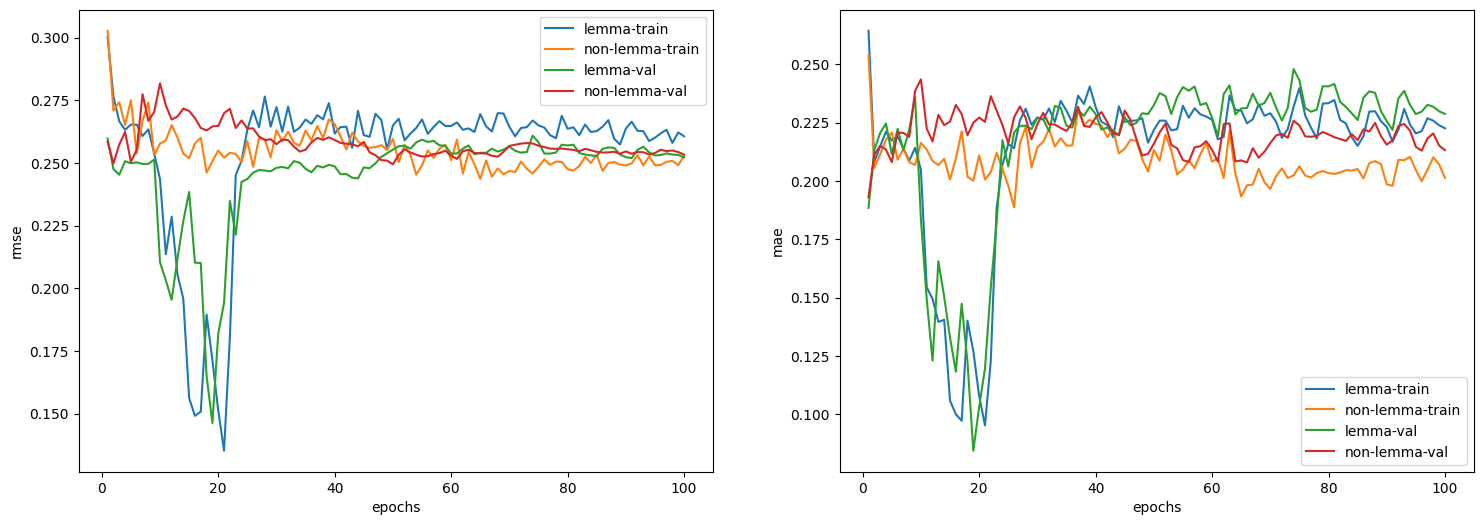

testing on ['raw_train', 'adjective_list']


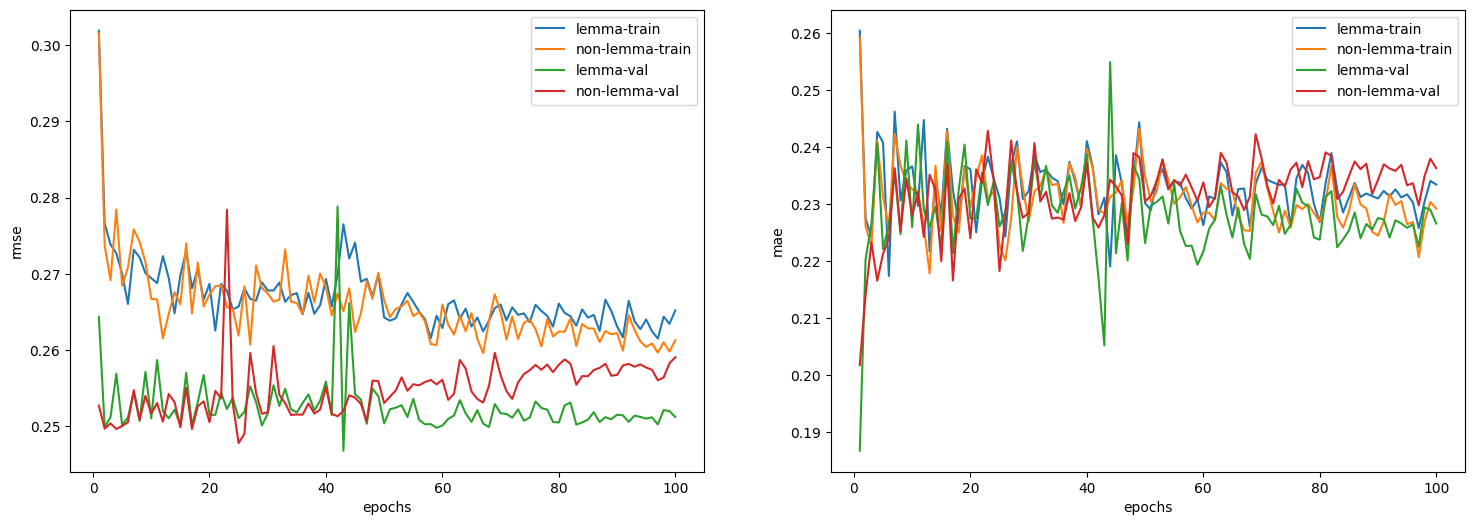

testing on ['raw_train', 'adjective_list', 'clauses on raw']


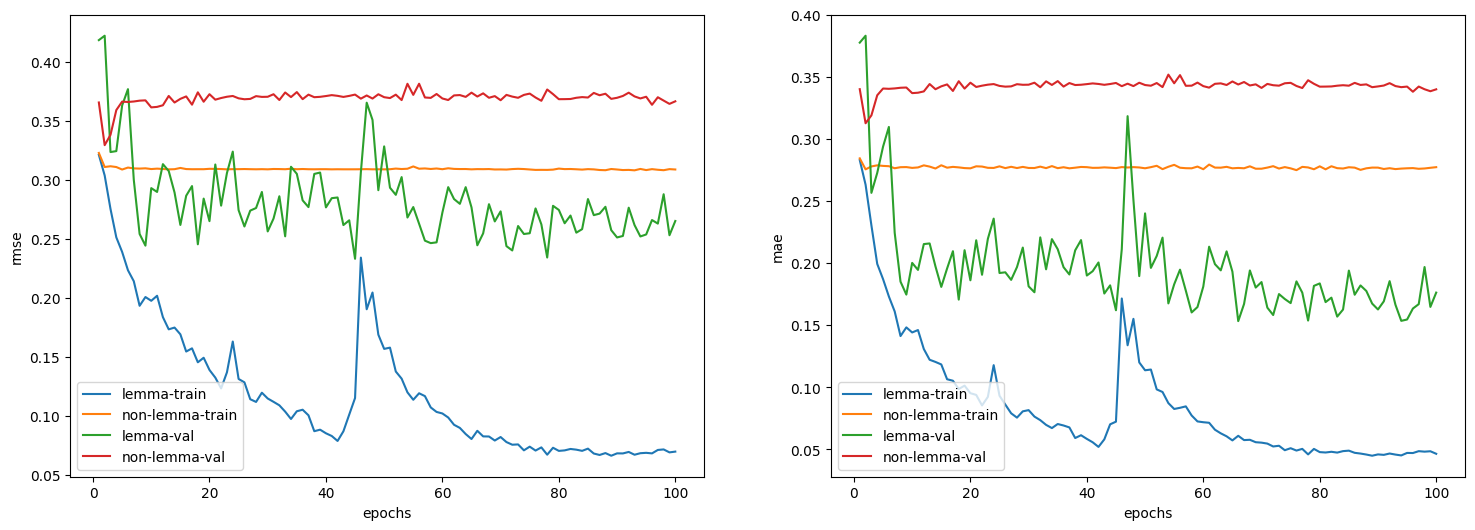

testing on ['raw_train', 'adjective_list', 'clauses on raw', 'adjective swap on raw']


In [ ]:
data_parts = [
  augmentable_df,
  adjective_list[['Review' , 'Score']] ,
  additional_data_english,
  adjective_swapped_raw,
  adjective_swaped_cluases,
]

data_names = ['raw_train' , 'adjective_list' , 'clauses on raw' , 'adjective swap on raw' , 'adjective swap on clause']
overall_rmse_lem = []
overall_mae_lem = []
overall_rmse= []
overall_mae= []

joined_data = pd.DataFrame({ 'Review': [] , 'Score': []})

for i , data in enumerate(data_parts):
  data_names_joined = data_names[:i + 1]
  print(f'testing on {data_names_joined}')

  joined_data = pd.concat([joined_data , data] , ignore_index=True)
  joined_data.drop_duplicates(subset='Review' , inplace=True)

  # prep data and test
  joined_data['Review'] = joined_data['Review'].apply(clean_text)
  joined_data['Review'] = joined_data['Review'].apply(remove_stopwords)

  # lemmatize
  
  joined_data['Lemmatized_Reviews'] = joined_data['Review'].apply(lemmatize_reviews)

  # attempting on lemmatized 
  tokenizer = Tokenizer(oov_token="<OOV>")
  tokenizer.fit_on_texts(joined_data['Lemmatized_Reviews'])
  lem_vocab_size = len(tokenizer.word_index) + 1

  lem_sequences_train = tokenizer.texts_to_sequences(joined_data['Lemmatized_Reviews'])
  lem_sequences_val = tokenizer.texts_to_sequences(val_data_df['Lemmatized_Reviews'])
  lem_sequences_test = tokenizer.texts_to_sequences(test_data_df['Lemmatized_Reviews'])
  
  # attempting on non-lemma
  tokenizer = Tokenizer(oov_token="<OOV>")
  tokenizer.fit_on_texts(joined_data['Review'])

  sequences_train = tokenizer.texts_to_sequences(joined_data['Review'])
  sequences_val = tokenizer.texts_to_sequences(val_data_df['Review'])
  sequences_test = tokenizer.texts_to_sequences(test_data_df['Review'])

  # callbacks 
  early_stopper = EarlyStopping(patience=5 , monitor='val_rmse' , mode='min', restore_best_weights=True)
  lr_reducer = ReduceLROnPlateau(
      monitor='val_rmse',
      factor=0.5,
      patience=5,
      min_lr=1e-6,
      verbose=1
  )

  # padding
  lem_max_len = max([len(s) for s in lem_sequences_train])
  padded_sequences_lem = pad_sequences(lem_sequences_train, padding='post', maxlen=lem_max_len)
  padded_val_sequences_lem = pad_sequences(lem_sequences_val, padding='post' , maxlen=lem_max_len)

  non_lem_max_len = max([len(s) for s in sequences_train])
  padded_sequences= pad_sequences(sequences_train, padding='post', maxlen=non_lem_max_len)
  padded_val_sequences= pad_sequences(sequences_val, padding='post' , maxlen=non_lem_max_len)
  
  # setting up plots
  fig , ax = plt.subplots(1 , 2 , figsize=(18 , 6))

  # Training on lem
  baseline_model_lem = create_baseline_model(input_dim=lem_vocab_size, input_length=lem_max_len)
  lem_results = baseline_model_lem.fit(padded_sequences_lem, joined_data['Score'],
              batch_size=32,
              epochs=100,
              validation_data=(padded_val_sequences_lem, val_data_df['Score']),
              verbose = 0
  )

  # Train on no lem
  baseline_model_no_lem = create_baseline_model(input_dim=lem_vocab_size, input_length=non_lem_max_len)
  non_lem_results = baseline_model_no_lem.fit(padded_sequences, joined_data['Score'],
              batch_size=32,
              epochs=100,
              validation_data=(padded_val_sequences, val_data_df['Score']),
              verbose = 0
  )

  # Storing data
  overall_rmse_lem.append(max(lem_results.history['val_rmse']))
  overall_mae_lem.append(max(lem_results.history['val_mean_absolute_error']))

  overall_rmse.append(max(non_lem_results.history['val_rmse']))
  overall_mae.append(max(non_lem_results.history['val_mean_absolute_error']))

  # Plotting 
  epochs = range(1 , max(len(non_lem_results.history['val_rmse']) , len(lem_results.history['val_rmse'])) + 1)
  ax[0].plot(epochs , lem_results.history['rmse'], label='lemma-train')
  ax[0].plot(epochs , non_lem_results.history['rmse'] , label='non-lemma-train')
  ax[0].plot(epochs , lem_results.history['val_rmse'], label='lemma-val')
  ax[0].plot(epochs , non_lem_results.history['val_rmse'] , label='non-lemma-val')
  ax[0].legend()
  ax[0].set_ylabel('rmse')
  ax[0].set_xlabel('epochs')

  ax[1].plot(epochs , lem_results.history['mean_absolute_error'], label='lemma-train')
  ax[1].plot(epochs , non_lem_results.history['mean_absolute_error'] , label='non-lemma-train')
  ax[1].plot(epochs , lem_results.history['val_mean_absolute_error'], label='lemma-val')
  ax[1].plot(epochs , non_lem_results.history['val_mean_absolute_error'] , label='non-lemma-val')
  ax[1].legend()
  ax[1].set_ylabel('mae')
  ax[1].set_xlabel('epochs')

  plt.show()

# overall plotting
x_axis = range(1 , len(data_names) + 1)

fig , ax = plt.subplots(1 ,2 , figsize=(18 , 12))

ax[0].plot(x_axis , overall_mae_lem, label='lem')
ax[0].plot(x_axis, overall_mae, label='non-lem')
ax[0].set_xticks(x_axis)
ax[0].set_xticklabels(data_names)
ax[0].set_title('mae against data')
ax[0].set_xlabel('data')
ax[0].set_ylabel('mae')

ax[1].plot(x_axis , overall_rmse_lem, label='lem')
ax[1].plot(x_axis, overall_rmse, label='non-lem')
ax[1].set_xticks(x_axis)
ax[1].set_xticklabels(data_names)
ax[1].set_title('rmse against data')
ax[1].set_xlabel('data')
ax[1].set_ylabel('rmse')

plt.show()

In [421]:
train_data_df.drop_duplicates(subset='Review' , inplace=True)
train_data_df

,Review,Score
0,The action sequences in Avengers: Endgame are ...,0.90
1,This film is a masterpiece! The storytelling i...,0.95
2,I like the way this movie combines comedy with...,0.85
3,While the main actors deliver commendable perf...,0.25
4,"Too many action scenes, sometimes unnecessary....",0.35
...,...,...
7622,Avengers: Endgame expertly balances moments of...,0.85
7623,Avengers: Endgame expertly balances moments of...,0.85
7624,Avengers: Endgame expertly balances moments of...,0.85
7625,Avengers: Endgame expertly balances moments of...,0.85


In [282]:
# we can export it as such
train_data_df.to_csv(os.path.join('stored_data' , 'cleaned_data' , 'train_data_df.csv') , index=False)

In [283]:
train_data_df = pd.read_csv(os.path.join('stored_data' , 'cleaned_data' , 'train_data_df.csv'))

In [284]:
train_data_df

,Review,Score
0,The action sequences in Avengers: Endgame are ...,0.10
1,This film is a masterpiece! The storytelling i...,0.05
2,I like the way this movie combines comedy with...,0.15
3,While the main actors deliver commendable perf...,0.75
4,"Too many action scenes, sometimes unnecessary....",0.65
...,...,...
18641,Avengers: Endgame expertly balances moments of...,0.12
18642,Avengers: Endgame expertly balances moments of...,0.12
18643,Avengers: Endgame expertly balances moments of...,0.12
18644,Avengers: Endgame expertly balances moments of...,0.12


##### Data Preperation

It is important that my **testing and validation data go through the same preprocessing steps**

In [423]:
# we can also export it
val_data_df.to_csv(os.path.join('stored_data' , 'cleaned_data' , 'val_data_df.csv'), index=False)
test_data_df.to_csv(os.path.join('stored_data' , 'cleaned_data' , 'test_data_df.csv'), index=False)

In [425]:
train_data_df['Review'] = train_data_df['Review'].apply(clean_text)
val_data_df['Review'] = val_data_df['Review'].apply(clean_text)
test_data_df['Review'] = test_data_df['Review'].apply(clean_text)

In [426]:
def lemmatize_reviews(x):
  lemmatizer = WordNetLemmatizer()
  words = word_tokenize(x)
  lemmatized_review_words = [lemmatizer.lemmatize(word) for word in words]
  return ' '.join(lemmatized_review_words)
                  



In [427]:
train_data_df['Lemmatized_Reviews'] = train_data_df['Review'].apply(lemmatize_reviews)
val_data_df['Lemmatized_Reviews'] = val_data_df['Review'].apply(lemmatize_reviews)
test_data_df['Lemmatized_Reviews'] = test_data_df['Review'].apply(lemmatize_reviews)

In [428]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_data_df['Lemmatized_Reviews'])

sequences_train = tokenizer.texts_to_sequences(train_data_df['Lemmatized_Reviews'])
sequences_val = tokenizer.texts_to_sequences(val_data_df['Lemmatized_Reviews'])
sequences_test = tokenizer.texts_to_sequences(test_data_df['Lemmatized_Reviews'])

In [ ]:
def create_model(
  input_dim,
  n,
  neurons,
  output_dim,
  dropout,
  input_length,
  lr,
):
  model = Sequential()
  model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

  for i in range(n):
    model.add(LSTM(round(neurons) , return_sequences=(i != n - 1) , dropout=dropout))
    model.add(BatchNormalization())
    neurons /= 2

  model.add(Dropout(dropout))
  model.add(Dense(64 , activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(1 , activation='sigmoid'))
  model.compile(loss='mean_squared_error' , optimizer=Adam(learning_rate = lr), metrics=['mean_absolute_error', RootMeanSquaredError('rmse')])

  return model


In [433]:
hyper_params = {
  'max_len': [90 , 95 , 100],  
  'n': [1 , 2],
  'output_dim': [128, 256, 512],
  'neurons': [64 , 128 , 256],
  'dropout': np.arange(0.5 , 0.9 , 0.1), 
  'lr': [1e-3 , 3e-3 , 1e-4 , 5e-4 , 1e-5],
  'batch_size': [16 , 32 , 64]
}

In [434]:
val_losses = []
val_rmses = []
fit_history = []
successful_params = []

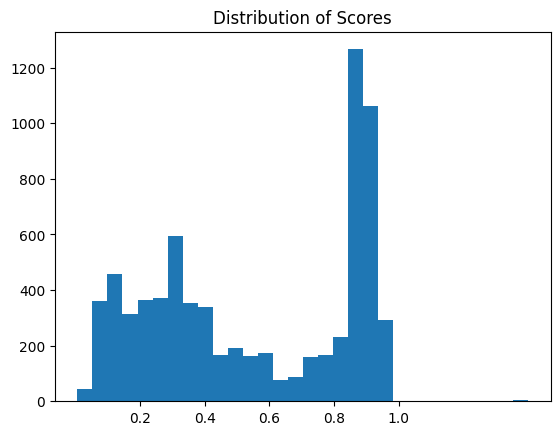

In [438]:
plt.hist(train_data_df['Score'], bins=30)
plt.title('Distribution of Scores')
plt.xticks(np.arange(0.2 , 1.2 , 0.2))
plt.show()

Seems that there is alot of positively skewed data when i was performing data augmentation.

Therefore i should try to use **RMSE** to handle the outliers

In [439]:
sequence_lens = [len(s) for s in sequences_train]
vocab_size = len(tokenizer.word_index) + 1

random.seed(888)

for params in list(ParameterGrid(hyper_params)):
  try:
    #padding sequences based on max len
    max_len = int(np.percentile(sequence_lens , params['max_len']))
    print(f'Tuning {params}...')

    padded_sequences = pad_sequences(sequences_train, padding='post', maxlen=max_len)
    padded_val_sequences = pad_sequences(sequences_val, padding='post' , maxlen=max_len)
    
    # Fit 
    early_stop = EarlyStopping(patience=5, restore_best_weights = True , monitor='val_rmse' , mode='min')
    lr_reducer = ReduceLROnPlateau(
        monitor='val_rmse',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    model = create_model(**{k:v for k , v in params.items() if k not in ['batch_size', 'max_len']} , input_dim=vocab_size, input_length=max_len)

    history = model.fit(padded_sequences, train_data_df['Score'],
              epochs = 100,
              batch_size= params['batch_size'],
              verbose = 0,
              validation_data = (padded_val_sequences, y_val),
              callbacks = [ early_stop, lr_reducer ] 
    )

    # evaluate and store
    val_loss , val_mae, val_rmse = model.evaluate(padded_val_sequences, y_val)
    print(f'val loss: {val_loss} , val mae : {val_mae}, val rmse {val_rmse}\n')

    val_losses.append(val_loss)
    val_rmses.append(val_rmse)
    fit_history.append(history.history)
    successful_params.append(params)

  except Exception as e:
    print(e)
    gc.collect()
    continue

Tuning {'batch_size': 16, 'dropout': 0.5, 'lr': 0.001, 'max_len': 90, 'n': 1, 'neurons': 64, 'output_dim': 128}...

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2/2 [==============================] - 0s 5ms/step - loss: 0.0391 - mean_absolute_error: 0.1535 - rmse: 0.1976
val loss: 0.03906215354800224 , val mae : 0.15345335006713867, val rmse 0.19764147698879242

Tuning {'batch_size': 16, 'dropout': 0.5, 'lr': 0.001, 'max_len': 90, 'n': 1, 'neurons': 64, 'output_dim': 256}...

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2/2 [==============================] - 0s 5ms/step - loss: 0.0486 - mean_absolute_error: 0.1757 - rmse: 0.2205
val loss: 0.04860168322920799 , val mae : 0.1757224202156067, val rmse 0.22045789659023285

Tuning {'batch_size': 16, 'dropout': 0.5, 'lr': 0.001, 'max_len': 90, 'n': 1, 'neurons': 64, 'output_dim': 512}...

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2/2 [============

KeyboardInterrupt: 

In [440]:
results = pd.DataFrame({
 'fit_results': fit_history,
 'val_losses': val_losses,
 'val_rmses': val_rmses,
 'successful_params': successful_params 
})

In [441]:
with open(os.path.join('tuning_results' , 'rnn_tuning.pkl') , 'wb') as f:
  pickle.dump(results, f)